In [9]:
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import wrf 
import glob 
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D

In [10]:
#Create Path For Data Collection and Create A List of File Names
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')

In [11]:
#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
storm_data = xr.open_dataset(storm16_data_path + storm16_files[-1])

#Dataset Domain Size
ni = storm_data['ni']
nj = storm_data['nj']
nk = storm_data['nk']

#Datapoint Locations
x_data = storm_data['xh']*units.kilometer
y_data = storm_data['yh']*units.kilometer
z_data = storm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm_data['xf']*units.kilometer
y_grid = storm_data['yf']*units.kilometer
z_grid = storm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values - (x_data.max().values-25)).argmin()-2
upper_bound_x = np.abs(x_data.values - (x_data.max().values)).argmin()
lower_bound_y = np.abs(y_data.values + 25).argmin()
upper_bound_y = np.abs(y_data.values).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(1,len(storm16_files),1):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0]+30 #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

In [12]:
#Step 2: Reading Different DataFields

#all files for storm 16
all_files = sorted(glob.glob(storm16_data_path+"*.nc"))

#remove the first file which is the initial field at t = 12 hrs and the outstatistics at the end
file_paths = all_files[1:-1]

#Manually open and extract the required variables from each dataset
orig_data = []

for f in tqdm(file_paths):
    
    read = xr.open_dataset(f)[['uinterp', 'vinterp', 'winterp', 'th','prs','qv', 'zvort']]
    
    orig_data.append(read)
    #except KeyError:
        #print(f"KeyError encountered while processing file: {f}")


100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


In [13]:
#Read in Raw Trajectories (Need to Update This Once the Interpolation Scheme Stops Running)

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

# Load arrays from .npz file
raw_data = np.load(path+'rawtrajectories.npz')

#Reassign Each Array
points = raw_data['interp_points']
uhodo_tmp = raw_data['interp_u']
vhodo_tmp = raw_data['interp_v']
whodo_tmp = raw_data['interp_w']

#Find Point Where Trajectories Break Off if Need Be 
index = 0
for t in tqdm(range(time[0], time[-1], dt)):
    if np.any(points[index][:,0]) == 0.0:
        breakpoint = index  #point where the trajectories stops+1
        break
    index += 1
    
#Readjust Data
raw_points = points[:breakpoint]
raw_uinterp = uhodo_tmp[:breakpoint]
raw_vinterp = vhodo_tmp[:breakpoint]
raw_winterp = whodo_tmp[:breakpoint]

 98%|█████████▊| 349/357 [00:00<00:00, 4473.60it/s]


In [14]:
for key in raw_data.keys():
    print(key)

interp_points
interp_u
interp_v
interp_w


# Everything Below Pertains to Interpolation to the Raw Trajectory Points

In [15]:
def master_interpolator_t(analtime, time, data):
    #first we need to interpolate all fields based on the time we are currently at
    
    #Find times that are before and after the interpolation time
    before_indices = np.where(time <= analtime)[0]
    after_indices = np.where(time >= analtime)[0]
    
   
    #raise an error if the time at which interpolation occurs lies outside of the time interval of data
    if len(before_indices) == 0 or len(after_indices) == 0:
        raise ValueError('analysis time lies outside of the time interval')
    
    #indices closest before & after the interpolation time
    Bindex = before_indices[-1]
    Aindex = after_indices[0]
    
    #if time we are interpolating is the same as one of the data timesteps, just return original data at that timestep
    if time[Bindex] == analtime:
        interp_data = data[Bindex].isel(time=0)
        return interp_data
    elif time[Aindex] == analtime:
        interp_data = data[Aindex].isel(time=0)
        return interp_data
    
    #saving data locally cuts down computation time
    before_data = data[Bindex][['th','prs','qv','zvort']].isel(time=0)
    after_data = data[Aindex][['th','prs','qv','zvort']].isel(time=0)
    
    #temporal interpolation of each field individually
    
    
    #interp_u = before_data['uinterp'].values +  (
        #(after_data['uinterp'].values - 
        # before_data['uinterp'].values) *
        #(analtime - time[Bindex]) /
        #(time[Aindex] - time[Bindex])
    #)
    
    interp_th = before_data['th'].values + (
        (after_data['th'].values -
         before_data['th'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex]) 
    )
    
    interp_pres = before_data['prs'].values + (
        (after_data['prs'].values -
         before_data['prs'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex]) 
    )
    
    interp_qv = before_data['qv'].values + (
        (after_data['qv'].values -
         before_data['qv'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex]) 
    )
    interp_zvort = before_data['zvort'].values + (
        (after_data['zvort'].values -
         before_data['zvort'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex]) 
    )
    
    
    dims = ('nk', 'nj', 'ni')
    
    #returns dataset of velocity fields in a small cloud based on the previous interpolation point to save computing resources/time
    return xr.Dataset({'th': (dims,interp_th), 'prs': (dims, interp_pres), 'qv': (dims,interp_qv), 'zvort': (dims,interp_zvort)}, coords={'ni': ni,'nj': nj,'nk': nk});
    

In [16]:
def master_interpolator_s(points, data):
    
    #establish the grid
    x = x_data.values
    y = y_data.values 
    z = z_data.values
    
    th, p, qv, zvort = [data['th'].values, data['prs'].values, data['qv'].values, data['zvort'].values]
    
    #Create Interpolation Functions 
    interpolator_th = RegularGridInterpolator((z,y,x), th)
    interpolator_p = RegularGridInterpolator((z,y,x), p)
    interpolator_qv = RegularGridInterpolator((z,y,x), qv)
    interpolator_zvort = RegularGridInterpolator((z,y,x), zvort)
    
    #Interpolate The Data
    interp_th = interpolator_th(points)
    interp_p = interpolator_p(points)
    interp_qv = interpolator_qv(points)
    interp_zvort = interpolator_zvort(points)
    
    return interp_th, interp_p, interp_qv, interp_zvort;
    

In [17]:
#Interpolate Data Along Raw Trajectory Points (Only need to run this once)

#Create Storage
raw_interp_th = np.zeros((breakpoint, horiz_length**2))
raw_interp_p = np.zeros((breakpoint, horiz_length**2))
raw_interp_qv = np.zeros((breakpoint, horiz_length**2))
raw_interp_zvort = np.zeros((breakpoint, horiz_length**2))

for i in tqdm(np.arange(0,breakpoint,1)):
    #Inteperpolate the fields to the current time
    interp_data_t = master_interpolator_t(int_time[i], time, orig_data)
    #interpolate to the points found in previous trajectory calculations (raw trajectory points)
    raw_interp_th[i], raw_interp_p[i], raw_interp_qv[i], raw_interp_zvort[i] = master_interpolator_s(raw_points[i], interp_data_t)
    


  0%|          | 0/349 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [10]:
#Before moving forward, save all interpolated data so we don't need to recalculate each time

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

#Save as a .npz file
np.savez(path+'interpolation_2_rawtrajectories', interp_points = raw_points, interp_u = raw_uinterp,
         interp_v = raw_vinterp, interp_w = raw_winterp, interp_th = raw_interp_th, interp_p = raw_interp_p, interp_qv = raw_interp_qv, interp_zvort = raw_interp_zvort)


# Everything Below Pertains to Interpolation to CM1 Grid

In [18]:
#Start with this cell if data is already interpolated

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

#read full dataset in
full_data = np.load(path + "interpolation_2_rawtrajectories.npz")

#Create Variables 
interp_points = full_data['interp_points']
interp_u = full_data['interp_u']
interp_v = full_data['interp_v']
interp_w = full_data['interp_w']
interp_th = full_data['interp_th']
interp_p = full_data['interp_p']
interp_qv = full_data['interp_qv']
interp_zvort = full_data['interp_zvort']

Text(0.5, 0, 'water vapor mixing ratio (kg/kg)')

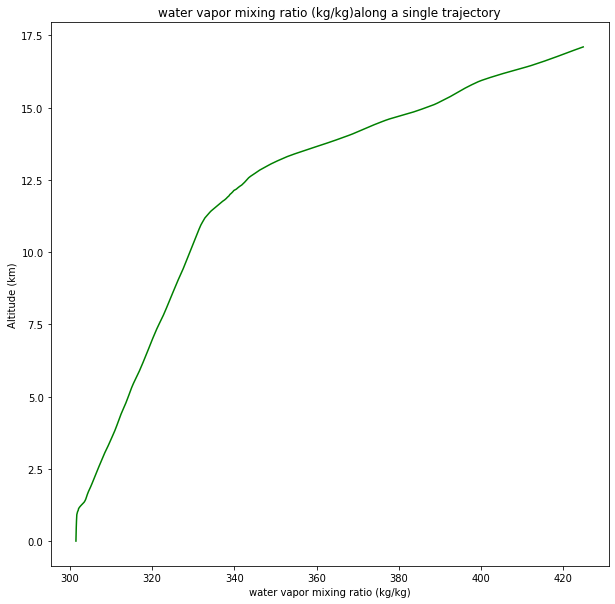

In [19]:
#Plot values along one trajectory to check data
fig = plt.figure(figsize=(10,10))
#plt.plot(interp_p[:,1],interp_points[:,1,0], color = 'k', label = 'pressure (Pa)')
plt.plot(interp_th[:,1],interp_points[:,1,0], color = 'g', label = 'potential temp (K)')
#plt.plot(interp_qv[:,1],interp_points[:,1,0], color = 'b', label = 'wv mix ratio (kg/kg)')
label = 'potential temp (K)'
label = 'pressure (Pa)'
label = 'water vapor mixing ratio (kg/kg)'
plt.title(label+"along a single trajectory")
plt.ylabel('Altitude (km)')
plt.xlabel(label)


In [20]:
#Takes Raw Data Along Trajectories and Interpolates down to original z_grid in model domain
#NEED TO ASK ABOUT IF LINEAR INTERPOLATION IS FINE 
def interp_to_grid(z_points, pressure, potential_temperature, qv, u_velocity, v_velocity, w_velocity, zvort):
    #Variables
    #z_points = z_values for raw interpolated data
    #z_levels = z levels in model domain 
    
    #Raw Interpolated Data
    #pressure (Pa)
    #potential_temperature (K)
    #qv - water vapor mixing ratio (kg/kg)
    #u_velocity - u component of velocity (m/s)
    #v_velocity - v component of velocity (m/s)
    
    z_levels = z_data.values
    z_points = z_points
    
    #Create Interpolator For Each Variable
    interpolator_pres = interp1d(z_points, pressure, fill_value = 'extrapolate')
    interpolator_pot_temp = interp1d(z_points, potential_temperature, fill_value = 'extrapolate')
    interpolator_qv = interp1d(z_points, qv, fill_value = 'extrapolate')
    interpolator_u = interp1d(z_points, u_velocity, fill_value = 'extrapolate')
    interpolator_v = interp1d(z_points, v_velocity, fill_value = 'extrapolate')
    interpolator_w = interp1d(z_points, w_velocity, fill_value = 'extrapolate')
    interpolator_zvort = interp1d(z_points, zvort, fill_value = 'extrapolate')
    
    #Interpolate to Model Domain height levels
    interp_pres = interpolator_pres(z_levels)
    interp_pot_temp = interpolator_pot_temp(z_levels)
    interp_qv = interpolator_qv(z_levels)
    interp_u = interpolator_u(z_levels)
    interp_v = interpolator_v(z_levels)
    interp_w = interpolator_w(z_levels)
    interp_zvort = interpolator_zvort(z_levels)
    
    #return values
    return interp_pres, interp_pot_temp, interp_qv, interp_u, interp_v, interp_w, interp_zvort;
    
    

In [21]:
#Interpolate Down To Original Grid (Currently Extrapololating On Upper End Because Not All Trajectories Finish)
#Might need to fix this if at the top of the domain the the extrapolation looks weird
#Some thoughts: The current way I'm storing data during the velocity/points calculations breaks 
#when trajectories finish early because it changes the shape of the calculations array. If I make brand new lists each time
# it could work better but might be too expensive

pressure = np.zeros((z_data.values.shape[0], horiz_length**2))
pot_temperature = np.zeros((z_data.values.shape[0], horiz_length**2))
u_velocity = np.zeros((z_data.values.shape[0], horiz_length**2))
v_velocity = np.zeros((z_data.values.shape[0], horiz_length**2))
w_velocity = np.zeros((z_data.values.shape[0], horiz_length**2))
zvort = np.zeros((z_data.values.shape[0], horiz_length**2))
qv = np.zeros((z_data.values.shape[0], horiz_length**2))

for i in tqdm(np.arange(0, interp_points.shape[1], 1 )):
    pressure[:,i], pot_temperature[:,i], qv[:,i], u_velocity[:,i], v_velocity[:,i], w_velocity[:,i], zvort[:,i] = interp_to_grid(interp_points[:,i,0],
                                                                                         interp_p[:,i], interp_th[:,i], interp_qv[:,i],
                                                                                         interp_u[:,i], interp_v[:,i], interp_w[:,i], interp_zvort[:,i])
    
    
    

100%|██████████| 112225/112225 [00:42<00:00, 2629.01it/s]


In [22]:
#Save The Data Interpolated Down to Model Domain
#Before moving forward, save all interpolated data so we don't need to recalculate each time

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

#Save as a .npz file
np.savez(path+'pseudodata_2_cm1grid', pressure = pressure, th = pot_temperature, qv = qv, u = u_velocity, v = v_velocity, w = w_velocity, zvort = zvort)


In [23]:
#Read in Raw Data Interpolated Down to Grid

path =  '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

#read full dataset in
interp_down_data = np.load(path + "pseudodata_2_cm1grid.npz")

#Create Variables 
pres_grid = interp_down_data['pressure']
th_grid = interp_down_data['th']
qv_grid = interp_down_data['qv']
u_grid = interp_down_data['u']
v_grid = interp_down_data['v']
w_grid = interp_down_data['w']
zvort = interp_down_data['zvort']
z_levels = z_data.values

100%|██████████| 112225/112225 [00:55<00:00, 2018.50it/s]


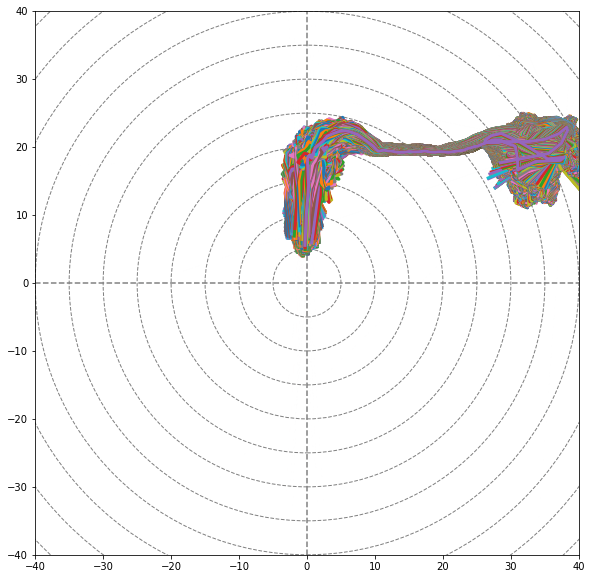

In [17]:
#Create Hodographs
#This doesn't look good due to the linear interpolation at the top of the domain
#look into the "kind" argument in scipy.interpolate.interp1d documentation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

offset_u = 12.2
offset_v = 12.5
fig, ax = plt.subplots(figsize = (10,10))
h = metpy.plots.Hodograph(ax, component_range=40.)
h.add_grid(increment=5)

for i in tqdm(range(335*335)):
    h.plot(u_grid[:,i]+offset_u, v_grid[:,i]+offset_v)

100%|██████████| 100/100 [00:00<00:00, 1537.29it/s]


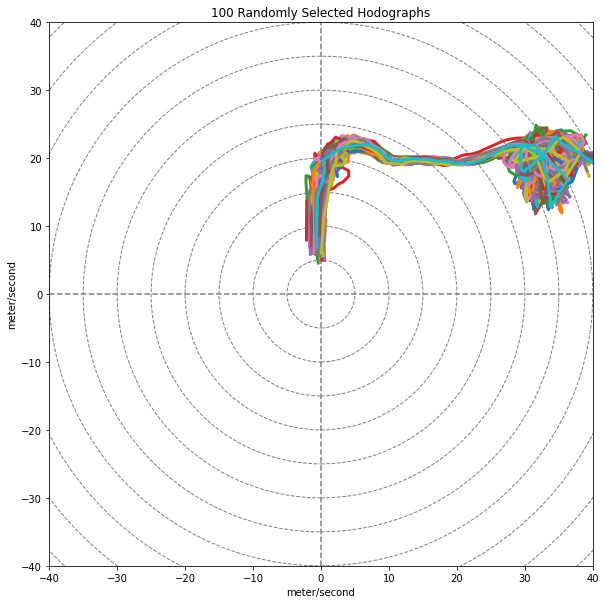

In [18]:
#Create Hodographs
#This doesn't look good due to the linear interpolation at the top of the domain
#look into the "kind" argument in scipy.interpolate.interp1d documentation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

offset_u = 12.2
offset_v = 12.5
fig, ax = plt.subplots(figsize = (10,10))
h = metpy.plots.Hodograph(ax, component_range=40.)
h.add_grid(increment=5)

for x in tqdm(range(100)):
    i = np.random.randint(0,335**2)
    h.plot(u_grid[:,i]+offset_u, v_grid[:,i]+offset_v)
    plt.title(f'100 Randomly Selected Hodographs')
    plt.xlabel('meter/second')
    plt.ylabel('meter/second')

In [19]:
#Create GIF of 100 Hodographs being plotted 

#Establish Path

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Figure Builder/'
gifname = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/GIFs/100indrandhodos.gif'

#initialize hodograph
offset_u = 12.2
offset_v = 12.5
fig, ax = plt.subplots(figsize = (10,10))
h = metpy.plots.Hodograph(ax, component_range=40.)
h.add_grid(increment=5)
plt.xlabel('meter/second')
plt.ylabel('meter/second')

for j in tqdm(range(100)):

    image_filename = "figure_%03d.png" % (j)
    i = np.random.randint(0,335**2)
    h.plot(u_grid[:,i]+offset_u, v_grid[:,i]+offset_v)
    plt.title(f'100 Randomly Selected Hodographs (Point ID: {i})')
    #Save the figure
    fig.savefig(path + image_filename)
    
    #clear 
    plt.close()

#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.25
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
#imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles[:j]:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames[:j]:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


# Below is Additional Computations That Must Be Added To Pseudo Dataset (CAPE, CIN, SRH, T, Td, Parc_T, etc.)

In [24]:
#Read in Raw Data Interpolated Down to Grid

path =  '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

#read full dataset in
interp_down_data = np.load(path + "pseudodata_2_cm1grid.npz")

#Create Variables 
pres_grid = interp_down_data['pressure']
th_grid = interp_down_data['th']
qv_grid = interp_down_data['qv']
u_grid = interp_down_data['u']
v_grid = interp_down_data['v']
w_grid = interp_down_data['w']
zvort = interp_down_data['zvort']
z_levels = z_data.values

In [25]:
for key in interp_down_data.keys():
    print(key)

pressure
th
qv
u
v
w
zvort


In [26]:
#Compute Temperature from pressure and potential temperature using adiabatic relationship
def comp_T_from_Th(pressure, pot_temperature):
    P_0 = 100000
    R_d = 287 #J/(kg*K)
    c_p = 1004 #J/(kg*K)
    K = R_d/c_p
    T = pot_temperature*(P_0/pressure)**(-K)
    
    return T;

#Compute Dewpoint Temperature from pressure, temperature, and specific humidity
def comp_dewpoint(pressure, temperature, specific_humidity):
    
    q = specific_humidity
    eps = 0.622
    
    #mixing ratio
    w = q/(1-q)
    
    #vapor pressure (in Pa converted to mb)
    e = 0.01*(pressure*w)/(eps+w)
    
    #Dewpoint from Bolton 1980
    T = (243.5*np.log(e/6.112))/(17.67-np.log(e/6.112))+273.15
    
    return T;

In [27]:
#Now Let's Work on Doing Calculations To Create Soundings (Only Run Once)

#Create New Variables

T = np.zeros(pres_grid.shape)
Td = np.zeros(pres_grid.shape)
parcel_prof = np.zeros(pres_grid.shape)

#I personally don't like metpy for the calculations. I'm going to create two functions that do metpy things better.
for i in tqdm(np.arange(0,pres_grid.shape[1],1)):
    T[:,i] = comp_T_from_Th(pres_grid[:,i], th_grid[:,i])
    Td[:,i] = comp_dewpoint(pres_grid[:,i], T[:,i], qv_grid[:,i])
    parcel_prof[:,i] = (metpy.calc.parcel_profile(pres_grid[:,i]*units.Pa, (T[:,i]*units.kelvin)[0], (Td[:,i]*units.kelvin)[0])).magnitude


100%|██████████| 112225/112225 [2:24:45<00:00, 12.92it/s] 


In [28]:
#Save The Data Interpolated Down to Model Domain
#Before moving forward, save all interpolated data so we don't need to recalculate each time

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

#Save as a .npz file
np.savez(path+'pseudodata_2_cm1grid', pressure = pres_grid, Th = th_grid, T = T, Td = Td, parc_T = parcel_prof, qv = qv_grid, u = u_grid, v = v_grid, w = w_grid, zvort = zvort)


In [29]:
#Read in Saved Data 
path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

data = np.load(path+'pseudodata_2_cm1grid.npz')

P = data['pressure']
T = data['T']
Td = data['Td']
Th = data['Th']
qv = data['qv']
u = data['u']
v = data['v']
w = data['w']
zvort = data['zvort']
parc_T = data['parc_T']

In [30]:
#Calculate CAPE, CIN, SRH1km, SRH3km

CAPE = np.zeros(P.shape)
CIN = np.zeros(P.shape)
SRH1km = np.zeros(P.shape[1])
SRH3km = np.zeros(P.shape[1])

for n in tqdm(np.arange(0,P.shape[1], 1)):
    results = wrf.cape_3d(P[:,n]/100, T[:,n], qv[:,n], z_data.values*1000, 0,P[0,n]/100,ter_follow = False,meta= False)
    CAPE[:,n] = results[0][:,0,0]
    CIN[:,n] = results[1][:,0,0]
    SRH1km[n] = (mpcalc.storm_relative_helicity(z_data.values*units.km, u[:,n]*units('m/s'), v[:,n]*units('m/s'), depth = 1000*units('m')))[0].magnitude
    SRH3km[n] = (mpcalc.storm_relative_helicity(z_data.values*units.km, u[:,n]*units('m/s'), v[:,n]*units('m/s'), depth = 3000*units('m')))[0].magnitude

100%|██████████| 112225/112225 [21:54<00:00, 85.39it/s]


In [31]:
#Save The Data Calculated So Far (Need to do CAPE,CIN,SRH1km, SRH3km)

path = '/storage/work/bsh5393/Masters Thesis/Near-Storm PseudoSoundings/CASE2-Southeastern Box/Data/'

np.savez(path+'pseudodata_2_cm1grid', P = P, T = T, Td = Td, Th = Th, qv = qv, u = u , v = v, w = w, zvort = zvort, parc_T = parc_T, CAPE = CAPE, CIN = CIN, SRH1km = SRH1km, SRH3km = SRH3km)
